In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
# load and prep data - same as EDA notebook
df = pd.read_csv('in_class_test(in).csv')

df['log_GDP'] = np.log1p(df['GDP per Capita'])
df['Gender_Female'] = (df['Gender'] == 'Female').astype(int)
df['Gender_Male'] = (df['Gender'] == 'Male').astype(int)

features = [
    'Infant Mortality Rate',
    'Birth Rate',
    'log_GDP',
    '% Population Aged 65+',
    'Gender_Female',
    'Gender_Male',
    'Year'
]

df_clean = df[features + ['Life Expectancy']].dropna()
X = df_clean[features]
y = df_clean['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

Train: 9,852
Test: 2,463


In [ ]:
# baseline models with defaults first
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)  # RF doesn't need scaling

models = [lr, rf]
names = ['Linear Regression', 'Random Forest']

print("Default parameters - Training performance:")
print("-"*50)
for i, model in enumerate(models):
    X_use = X_train_scaled if i == 0 else X_train
    pred = model.predict(X_use)
    print(f"{names[i]}:")
    print(f"  R2: {r2_score(y_train, pred):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_train, pred)):.2f}")

Default parameters - Training performance:
--------------------------------------------------
Linear Regression:
  R2: 0.8746
  RMSE: 3.55
Random Forest:
  R2: 0.9961
  RMSE: 0.63


In [ ]:
# RF likely overfitting - tune hyperparameters
rf_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10)
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    n_iter=20,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)

print(f"Best RF params: {rf_search.best_params_}")
print(f"Best CV R2: {rf_search.best_score_:.4f}")

rf_tuned = rf_search.best_estimator_

Best RF params: {'max_depth': 14, 'min_samples_split': 2, 'n_estimators': 98}
Best CV R2: 0.9653


In [ ]:
# final comparison on TEST data
lr_pred = lr.predict(X_test_scaled)
rf_pred = rf_tuned.predict(X_test)

print("TEST SET PERFORMANCE")
print("="*50)
print(f"{'Metric':<15} {'Linear Reg':>15} {'Random Forest':>15}")
print("-"*50)
print(f"{'R2':<15} {r2_score(y_test, lr_pred):>15.4f} {r2_score(y_test, rf_pred):>15.4f}")
print(f"{'RMSE':<15} {np.sqrt(mean_squared_error(y_test, lr_pred)):>15.2f} {np.sqrt(mean_squared_error(y_test, rf_pred)):>15.2f}")
print(f"{'MAE':<15} {mean_absolute_error(y_test, lr_pred):>15.2f} {mean_absolute_error(y_test, rf_pred):>15.2f}")

TEST SET PERFORMANCE
Metric               Linear Reg   Random Forest
--------------------------------------------------
R2                       0.8810          0.9704
RMSE                       3.45            1.72
MAE                        2.47            1.16


Linear Regression Coefficients (standardised):
---------------------------------------------
  Infant Mortality Rate          -6.478
  log_GDP                        +1.456
  Birth Rate                     -1.116
  Gender_Female                  +0.824
  Gender_Male                    -0.812
  % Population Aged 65+          +0.727
  Year                           -0.031


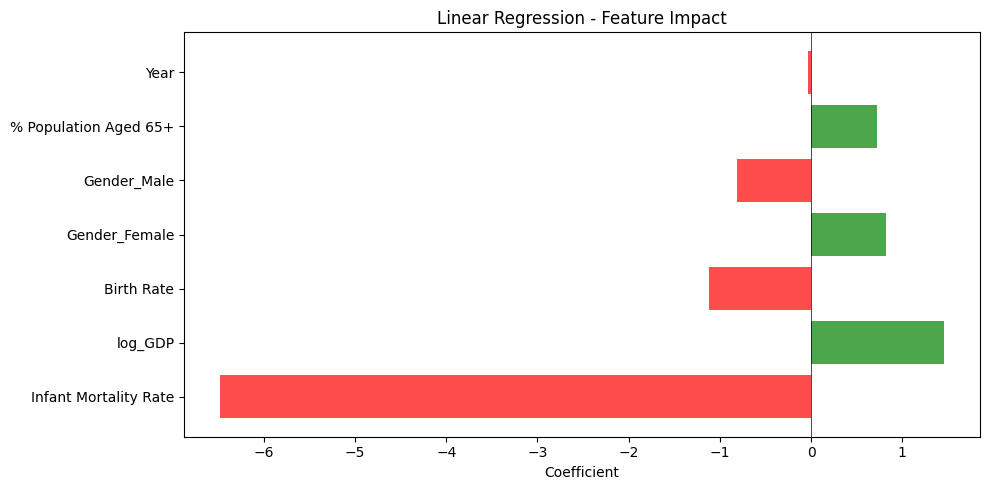

In [ ]:
# coefficient interpretation - key advantage of linear regression
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Linear Regression Coefficients (standardised):")
print("-"*45)
for _, row in coef_df.iterrows():
    direction = '+' if row['Coefficient'] > 0 else '-'
    print(f"  {row['Feature']:<30} {direction}{abs(row['Coefficient']):.3f}")

plt.figure(figsize=(10, 5))
colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', lw=0.5)
plt.xlabel('Coefficient')
plt.title('Linear Regression - Feature Impact')
plt.tight_layout()
plt.show()

Random Forest Feature Importance:
---------------------------------------------
  Infant Mortality Rate          0.8675
  log_GDP                        0.0319
  Birth Rate                     0.0293
  % Population Aged 65+          0.0289
  Year                           0.0169
  Gender_Female                  0.0135
  Gender_Male                    0.0121


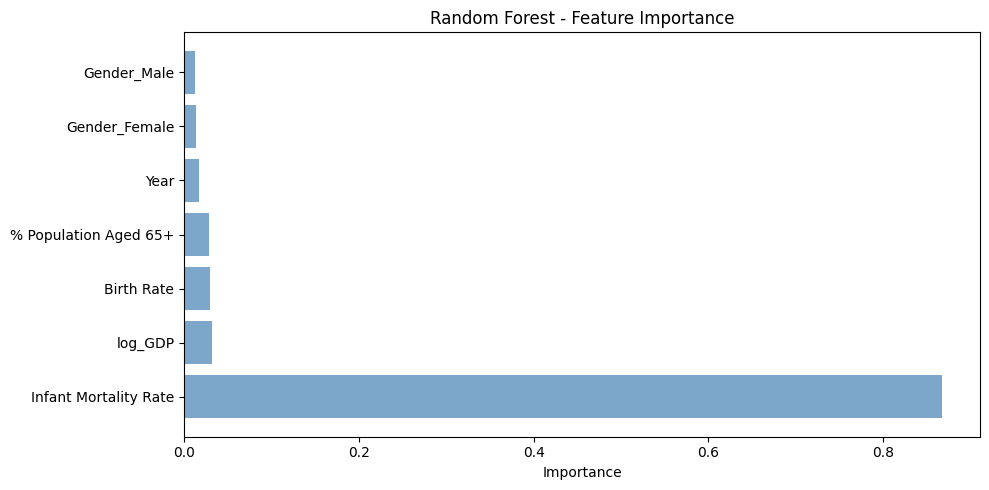

In [ ]:
# RF feature importance - tells us what matters but not how
imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importance:")
print("-"*45)
for _, row in imp_df.iterrows():
    print(f"  {row['Feature']:<30} {row['Importance']:.4f}")

plt.figure(figsize=(10, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

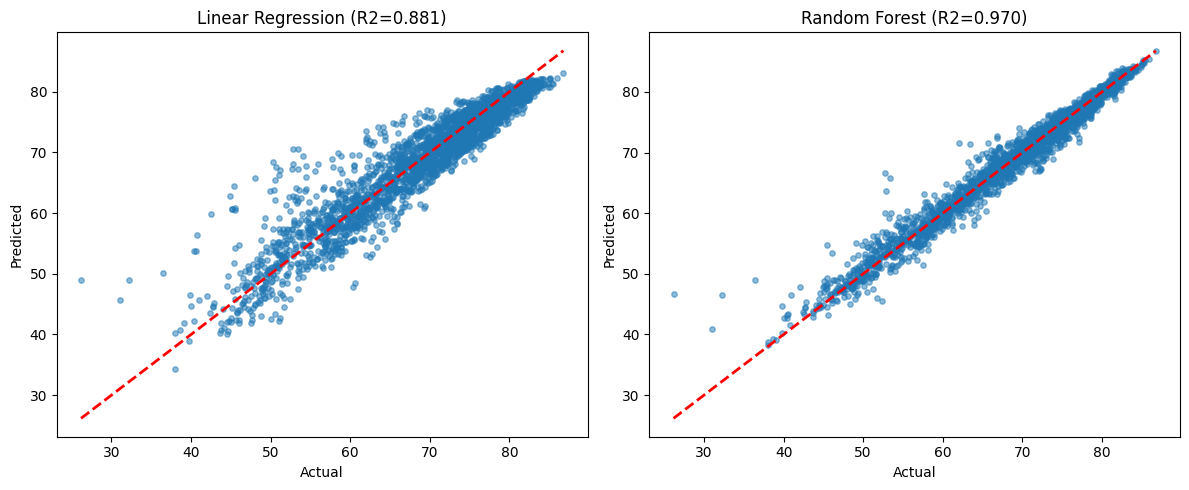

In [ ]:
# actual vs predicted plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test, lr_pred, alpha=0.5, s=15)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Linear Regression (R2={r2_score(y_test, lr_pred):.3f})')

axes[1].scatter(y_test, rf_pred, alpha=0.5, s=15)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Random Forest (R2={r2_score(y_test, rf_pred):.3f})')

plt.tight_layout()
plt.show()

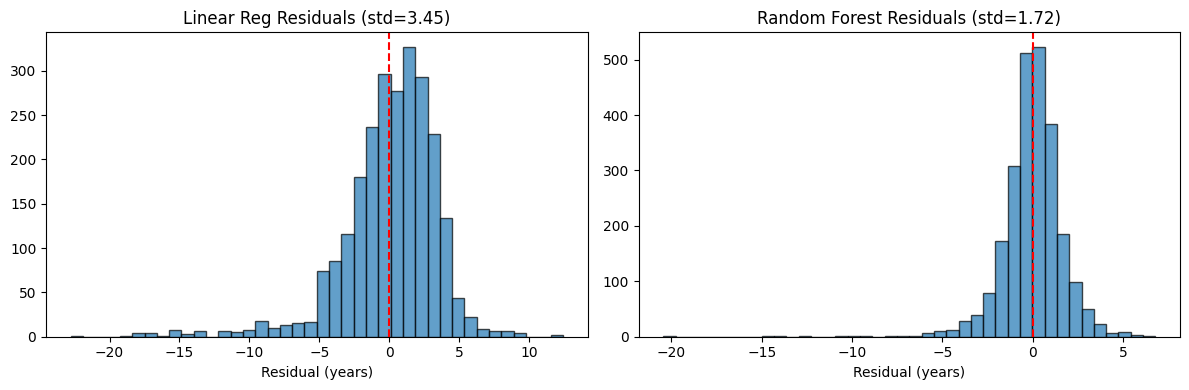

In [ ]:
# residual comparison
lr_resid = y_test - lr_pred
rf_resid = y_test - rf_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(lr_resid, bins=40, alpha=0.7, edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('Residual (years)')
axes[0].set_title(f'Linear Reg Residuals (std={lr_resid.std():.2f})')

axes[1].hist(rf_resid, bins=40, alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residual (years)')
axes[1].set_title(f'Random Forest Residuals (std={rf_resid.std():.2f})')

plt.tight_layout()
plt.show()

In [ ]:
print("="*60)
print("SUMMARY")
print("="*60)
print(f"\nLinear Regression:")
print(f"  - R2: {r2_score(y_test, lr_pred):.4f}")
print(f"  - Coefficients show infant mortality has strongest negative impact")
print(f"  - Stakeholders can verify: higher mortality = lower life expectancy")
print(f"\nRandom Forest:")
print(f"  - R2: {r2_score(y_test, rf_pred):.4f}")
print(f"  - Marginal improvement but cant explain direction of effects")
print(f"  - Feature importance confirms infant mortality matters most")
print(f"\nTradeoff: RF gains ~{(r2_score(y_test, rf_pred) - r2_score(y_test, lr_pred))*100:.1f}% R2")
print(f"but loses coefficient interpretability")
print("="*60)

SUMMARY

Linear Regression:
  - R2: 0.8810
  - Coefficients show infant mortality has strongest negative impact
  - Stakeholders can verify: higher mortality = lower life expectancy

Random Forest:
  - R2: 0.9704
  - Marginal improvement but cant explain direction of effects
  - Feature importance confirms infant mortality matters most

Tradeoff: RF gains ~8.9% R2
but loses coefficient interpretability


Random Forest edges out Linear Regression on R² but the gap is smaller than I expected given the complexity difference. The more useful output is actually the coefficient chart from Linear Regression since you can point at it and say higher infant mortality means lower life expectancy, and a domain expert can verify that makes sense. Random Forest just says infant mortality matters without telling you how. For policy decisions where you need to justify recommendations, that interpretability gap probably outweighs a few percentage points of accuracy.